# Étude du client 39

In [1]:
#import des librairies
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from joblib import dump

import sys
sys.path.append("../../scripts/")

# librairies perso
from import_data import import_data, import_data_complete
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure, permutation_feature_importance

In [2]:
np.random.seed(42)

In [3]:
data = import_data_complete(path = "../../")

In [4]:
# on sélectionne le bon client : 
client = 39
data = data.groupby("id_client").get_group(client)
data = data.reset_index()
data = data.drop(["index", "id_client", "prediction"], axis = 1 )

In [5]:
# création des dossiers utiles
folder1 = f"../../output/client{client}"
folder2 = f"../../output/client{client}/modèles"

# Vérifier si les dossier n'existe pas déjà
if not os.path.exists(folder1):
    os.makedirs(folder1)
if not os.path.exists(folder2):
    os.makedirs(folder2)

In [6]:
# création d'un dataFrame où on stocke les résulats
results = pd.DataFrame(columns = ["MSE", "MAE", "R2", "crossVal"])
def concat_results(name, result): 
    df = pd.DataFrame(result, columns = [name], index = results.columns).T
    return pd.concat([results, df])

# Traitement des données

## On enlève les NaN

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   horodate                760 non-null    datetime64[ns]
 1   real_consumption        760 non-null    float64       
 2   forecasted_consumption  760 non-null    float64       
 3   CAC                     760 non-null    float64       
 4   AEX                     760 non-null    float64       
 5   BFX                     760 non-null    float64       
 6   STOXX                   760 non-null    float64       
 7   Airliquide              760 non-null    float64       
 8   gasNat                  760 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 53.6 KB


In [8]:
data.dropna(axis=1, inplace=True)

## On enlève les zéros en trop 

In [9]:
non_zero = np.max(np.where(data["real_consumption"] != 0))
data = data.iloc[:non_zero, :]
data.to_csv(f"../../output/client{client}/client{client}.csv")
data

,horodate,real_consumption,forecasted_consumption,CAC,AEX,BFX,STOXX,Airliquide,gasNat
0,2021-01-01,5412.00,5525.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
1,2021-01-02,5084.00,5525.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
2,2021-01-03,5073.00,5525.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
3,2021-01-04,5070.00,5525.0,5614.040039,632.020020,3671.080078,3565.679932,123.590912,2.626
4,2021-01-05,5053.23,5525.0,5561.600098,629.940002,3645.760010,3554.239990,123.136360,2.599
...,...,...,...,...,...,...,...,...,...
741,2023-01-13,2554.54,5300.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
742,2023-01-14,2563.17,5300.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
743,2023-01-15,2562.80,5300.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
744,2023-01-16,2563.38,5300.0,7036.479980,748.940002,3944.040039,4155.740234,143.339996,3.677


# Visualisation des données

## Consommation prédite vs consommation réelle

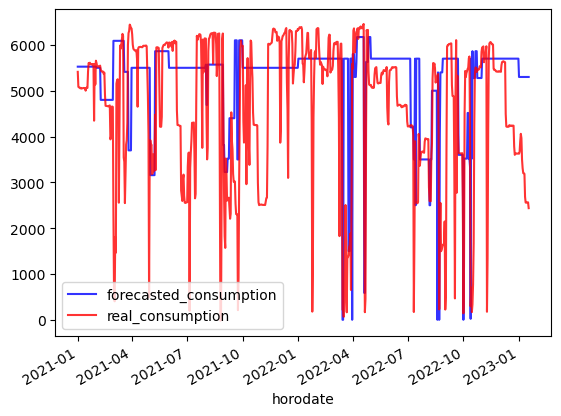

In [10]:
data.plot(x = "horodate", y = ["forecasted_consumption","real_consumption"], color = ["blue", "red"], alpha = 0.8)
plt.savefig(f"../../output/client{client}/forecasted_vs_real.jpg");

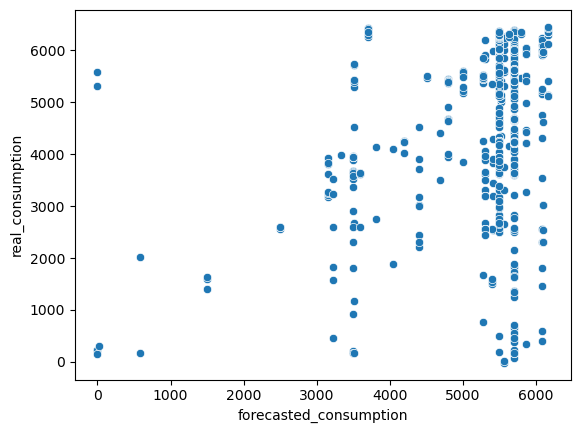

In [11]:
sns.scatterplot(x = "forecasted_consumption", y = "real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_forecasted_vs_real.jpg");

## Etude des corrélations

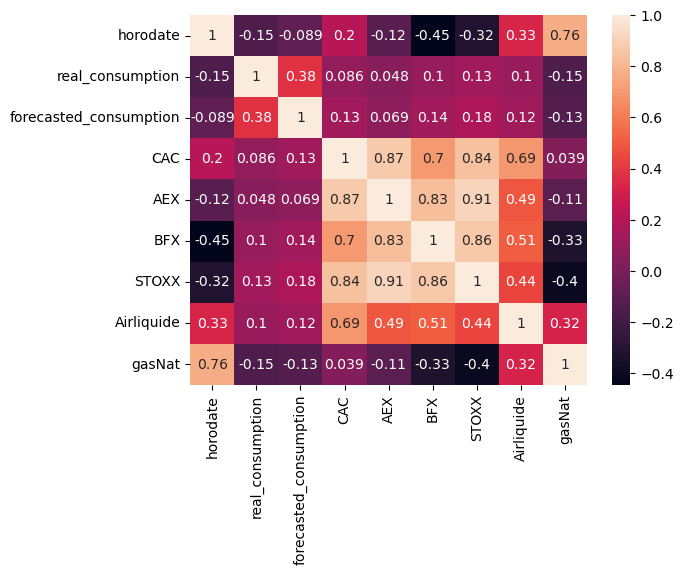

In [12]:
sns.heatmap(data.corr(), annot=True)
plt.savefig(f"../../output/client{client}/corr.png");

### CAC

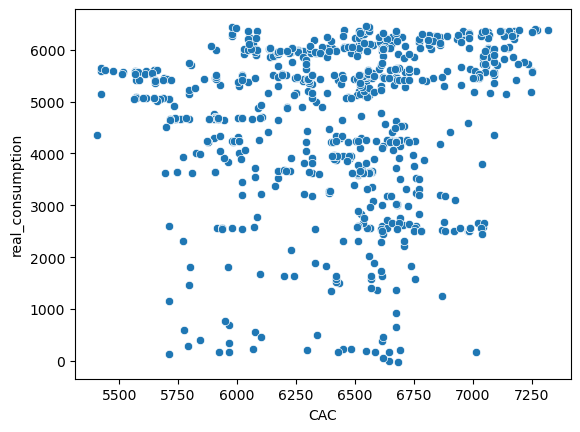

In [13]:
sns.scatterplot(x = "CAC", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_cac_real"); 

### BFX

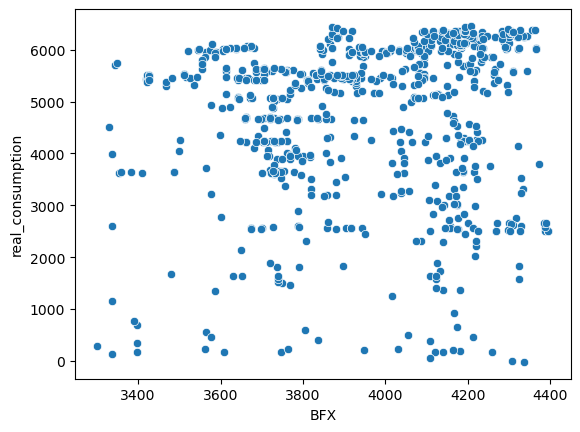

In [14]:
sns.scatterplot(x = "BFX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_bfx_real"); 

### AEX

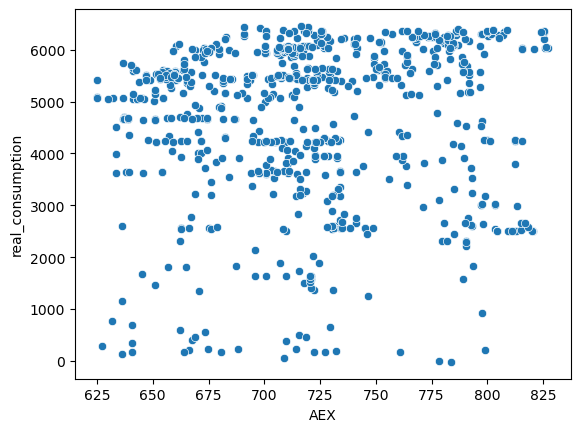

In [15]:
sns.scatterplot(x = "AEX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_aex_real"); 

### STOXX

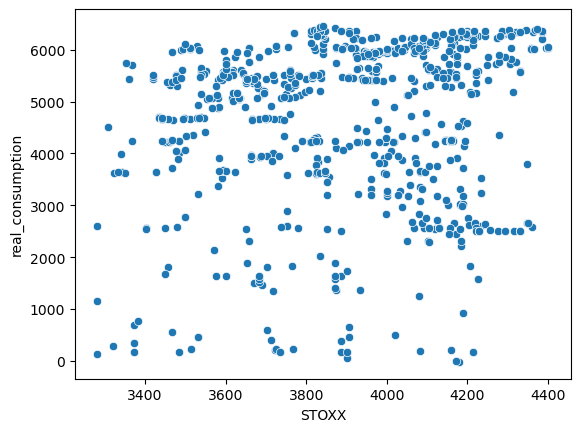

In [16]:
sns.scatterplot(x = "STOXX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_stoxx_real"); 

### Gas naturel

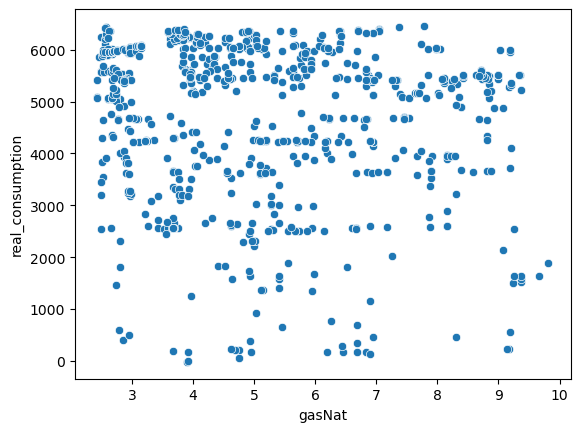

In [17]:
sns.scatterplot(x = "gasNat", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_gasNat_real"); 

# Application des modèles

## Modèle 1 : régression linéaire

### Avec une seule variable : forecasted_consumption

In [18]:
# découpage des sets de données
X = data[["forecasted_consumption"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [20]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

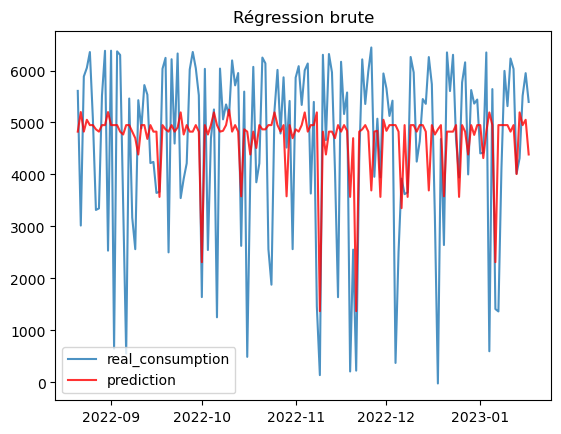

In [21]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression brute")
plt.legend()
plt.savefig(f"../../output/client{client}/simple_linear_regression.png");

#### Erreur de prédiction du client

In [22]:
# erreur entre la consommation réelle et celle prédite par le client
error = [mean_squared_error(y_test, X_test["forecasted_consumption"]), mean_absolute_error(y_test, X_test["forecasted_consumption"]), r2_score(y_test, X_test["forecasted_consumption"])]
error.append(np.NaN)
error

[3091507.8368886663, 1164.7974, -0.07594770806320028, nan]

In [23]:
results = concat_results("erreur_prediction_client",error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3.091508e+06,1164.7974,-0.075948,NaN


#### Erreur du modèle 

In [24]:
# erreur sur l'entrainement
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [25]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([ 0.08451798, -0.02311064,  0.14713851,  0.24990952,  0.19782751])

In [26]:
results = concat_results("erreur_régression_simple", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_régression_simple,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"


In [27]:
# enregistrement du modèle
dump(model, f'../../output/client{client}/modèles/simple_linear_regression.joblib');

### Avec toutes les données boursières

In [28]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [30]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

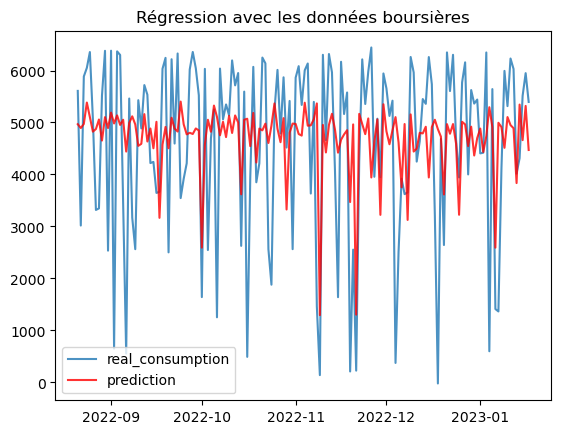

In [31]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression avec les données boursières")
plt.legend()
plt.savefig(f"../../output/client{client}/complet_linear_regression.png");

#### Erreur du modèle 

In [32]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error

[2479769.2497791206, 1211.7041675395105, 0.136957697797506]

In [33]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.09368151, 0.01173128, 0.13352909, 0.26909966, 0.20080582])

In [34]:
results = concat_results("erreur_régression_complète", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_régression_simple,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_régression_complète,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"


In [35]:
# enregistrement du modèle
dump(model, f'../../output/client{client}/modèles/complet_linear_regression.joblib');

## Modèle 2 : Random Forest

In [36]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [38]:
# création du modèle
model = RandomForestRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

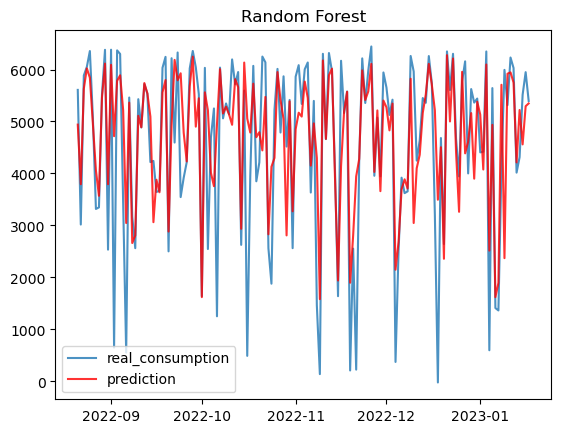

In [39]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Random Forest")
plt.legend()
plt.savefig(f"../../output/client{client}/random_forest.png");

#### Erreur du modèle

In [40]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [41]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.52022778, 0.5077651 , 0.45445726, 0.43682947, 0.43311946])

In [42]:
results = concat_results("random_forest", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_régression_simple,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_régression_complète,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
random_forest,1350703.036004,729.059481,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"


In [43]:
# enregistrement du modèle 
dump(model, f'../../output/client{client}/modèles/random_forest.joblib');

## Modèle 3 : Gradient Boosting

In [44]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [46]:
# création du modèle
model = GradientBoostingRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

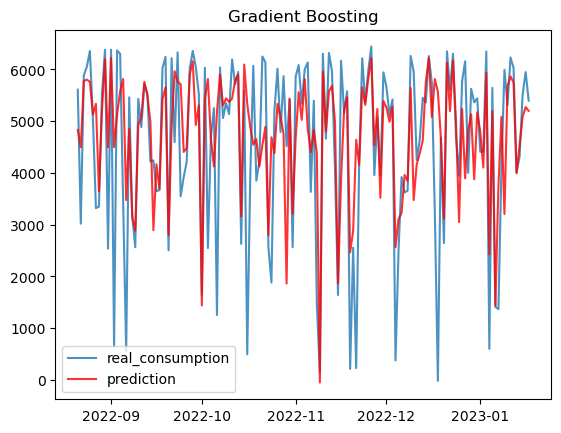

In [47]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Gradient Boosting")
plt.legend()
plt.savefig(f"../../output/client{client}/gradient_boosting.png");

#### Erreurs du modèle

In [48]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [49]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.40264165, 0.44594116, 0.32814791, 0.3372748 , 0.35219286])

In [50]:
results = concat_results("gradien_boosting", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_régression_simple,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_régression_complète,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
random_forest,1350703.036004,729.059481,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"
gradien_boosting,1751975.476564,845.520124,0.390254,"[0.403, 0.446, 0.328, 0.337, 0.352]"


In [51]:
# enristrement du modèle
dump(model, f"../../output/client{client}/modèles/gradient_boosting.joblib");

## Modèle 4 : Support vector machine

In [52]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [54]:
"""
# on règle la machine à vecteur de support 
param_grid = {
    'C': [100, 150, 200, 250],
    'kernel': ["poly"],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [1.0, 2.0, 3.0]
}

# Créer le modèle Gradient Boosting
SVM = SVR()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Effectuer la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train_norm, y_train)
grid_search.best_estimator_
"""

'\n# on règle la machine à vecteur de support \nparam_grid = {\n    \'C\': [100, 150, 200, 250],\n    \'kernel\': ["poly"],\n    \'gamma\': [\'scale\', \'auto\'],\n    \'degree\': [2, 3, 4],\n    \'coef0\': [1.0, 2.0, 3.0]\n}\n\n# Créer le modèle Gradient Boosting\nSVM = SVR()\n\n# Créer l\'objet GridSearchCV\ngrid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\n# Effectuer la recherche sur grille sur les données d\'entraînement\ngrid_search.fit(X_train_norm, y_train)\ngrid_search.best_estimator_\n'

In [55]:
model = SVR(C=250, coef0=3.0, degree=4, kernel='poly')

In [56]:
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

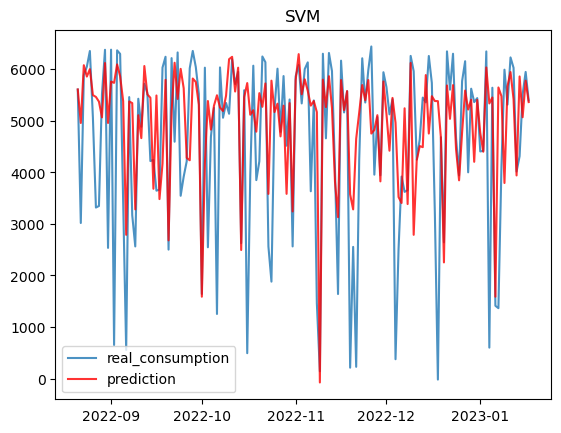

In [57]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("SVM")
plt.legend()
plt.savefig(f"../../output/client{client}/SVM.png");

#### Erreurs sur le modèle

In [58]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error

[2370668.5864044474, 961.723844727758, 0.17492836289026992]

In [59]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.14424301, 0.11153155, 0.24484082, 0.16888084, 0.4122931 ])

In [60]:
results = concat_results("SVM", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_régression_simple,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_régression_complète,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
random_forest,1350703.036004,729.059481,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"
gradien_boosting,1751975.476564,845.520124,0.390254,"[0.403, 0.446, 0.328, 0.337, 0.352]"
SVM,2370668.586404,961.723845,0.174928,"[0.144, 0.112, 0.245, 0.169, 0.412]"


In [61]:
# enregistrement du modèle
dump(model, f"../../output/client{client}/modèles/SVM.joblib");

In [62]:
# enregistrement des résultats 
results.to_csv(f"../../output/client{client}/results.csv")